# Гиперпараметры

In [ ]:
%%time  
import warnings                    
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2022-01-01')]

data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Блок 2: Определение функции для оценки модели
def evaluate_model(store_data, params):
    try:
        model = Prophet(**params)
        model.fit(store_data)
        df_cv = cross_validation(model, horizon='30 days')
        df_p = performance_metrics(df_cv)
        return df_p['mape'].mean()
    except Exception as e:
        print(f"Ошибка для параметров {params}: {e}")
        return float('inf')

# Блок 3: Исключенные магазины
excluded_stores = [149, 155, 164, 111, 123, 136, 127, 109]

# Блок 4: Сетка параметров
param_grid = [
    {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps, 'seasonality_mode': sm}
    for cps in [0.1, 0.05, 0.2, 0.5, 1.0, 0.75, 0.01]
    for sps in [1.0, 10.0, 25.0, 50.0, 75.0, 100.0]
    for sm in ['additive', 'multiplicative']
]

# Блок 5: Функция для параллельной обработки
def process_store(store):
    if store in excluded_stores:
        return store, None

    store_data = data[data['store'] == store]
    best_mape = float('inf')
    best_params = None

    for params in param_grid:
        mape = evaluate_model(store_data, params)
        if mape < best_mape:
            best_mape = mape
            best_params = params

    return store, best_params

# Параллельный расчет гиперпараметров для каждого магазина
results = Parallel(n_jobs=-1, backend="loky")(delayed(process_store)(store) for store in data['store'].unique())

# Сохранение параметров модели в файл
model_params = {store: params for store, params in results if params}
param_data = pd.DataFrame.from_dict(model_params, orient='index').reset_index()
param_data.columns = ['store', 'changepoint_prior_scale', 'seasonality_prior_scale', 'seasonality_mode']
param_data.to_excel('model_params+.xlsx', index=False)

# Рассчет прогноза

In [ ]:
%%time
import warnings               # Рассчет прогноза
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings("ignore")

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2021-01-01')]

# Подготовка данных для модели Prophet
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных для магазинов, которые присутствуют в DataFrame
store_ids = [186]                                                     #новые магазины
other_store_data = data[~data['store'].isin(store_ids)]
specified_store_data = data[data['store'].isin(store_ids)]

# Удаление строк с пропущенными значениями
other_store_data.dropna(inplace=True)
specified_store_data.dropna(inplace=True)

# Проверка количества строк после очистки
print(f'other_store_data имеет {len(other_store_data)} строк после очистки')
print(f'specified_store_data имеет {len(specified_store_data)} строк после очистки')

# Блок 2: Загрузка гиперпараметров модели
try:
    model_params = pd.read_excel('model_params_last.xlsx')
except FileNotFoundError:
    model_params = pd.DataFrame(columns=['store', 'changepoint_prior_scale', 'seasonality_prior_scale','seasonality_mode'])

# Блок 3: Предпраздничные даты и исключенные магазины
pre_holiday_dates = ['2025-02-22','2025-03-07','2025-05-08','2025-06-11','2025-04-20','2025-05-02','2025-05-03','2024-12-28','2024-12-29','2024-12-30','2024-12-31','2025-12-28','2025-12-29','2025-12-30','2025-12-31']  # Добавьте нужные даты
excluded_stores = [149, 155, 164, 111, 123, 136, 127, 109]  # Исключение магазинов из расчета

# Блок 4: Прогнозирование для магазинов, для которых указаны гиперпараметры
all_forecasts = pd.DataFrame()
for _, params in model_params.iterrows():
    store = params['store']
    if store in excluded_stores:
        continue

    store_data = other_store_data[other_store_data['store'] == store]

    if len(store_data) < 2:
        print(f'Пропускаем магазин {store} из-за недостатка данных')
        continue

    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(store_data)
                                                           # на 40 дней вперед по маг. с гиперпарам
    future = model.make_future_dataframe(periods=75)
    forecast = model.predict(future)
    forecast['store'] = store

    # Увеличение прогноза для каждой предпраздничной даты
    for pre_holiday_date in pre_holiday_dates:
        mask = forecast['ds'] == pd.to_datetime(pre_holiday_date)
        forecast.loc[mask, 'yhat'] *= 1.6                            # Увеличение на 1.165

    all_forecasts = pd.concat([all_forecasts, forecast])

# Блок 5: Прогнозирование для магазинов 180, 181, 183 с использованием стандартных гиперпараметров
for store in store_ids:
    store_data = specified_store_data[specified_store_data['store'] == store]

    if len(store_data) < 2:
        print(f'Пропускаем магазин {store} из-за недостатка данных')
        continue

    model = Prophet()
    model.fit(store_data)
                                               # на 40 дней вперед по маг. без гиперпарам
    future = model.make_future_dataframe(periods=75)
    forecast = model.predict(future)
    forecast['store'] = store

    # Увеличение прогноза для каждой предпраздничной даты
    for pre_holiday_date in pre_holiday_dates:
        mask = forecast['ds'] == pd.to_datetime(pre_holiday_date)
        forecast.loc[mask, 'yhat'] *= 1.6                                       # Увеличение на 16.5%

    all_forecasts = pd.concat([all_forecasts, forecast])

# Сохранение результатов прогноза в новом Excel-файле
selected_columns = ['ds', 'store', 'yhat', 'yhat_upper']
all_forecasts[selected_columns].to_excel('ForecastNext2Month.xlsx', index=False)

# Графики

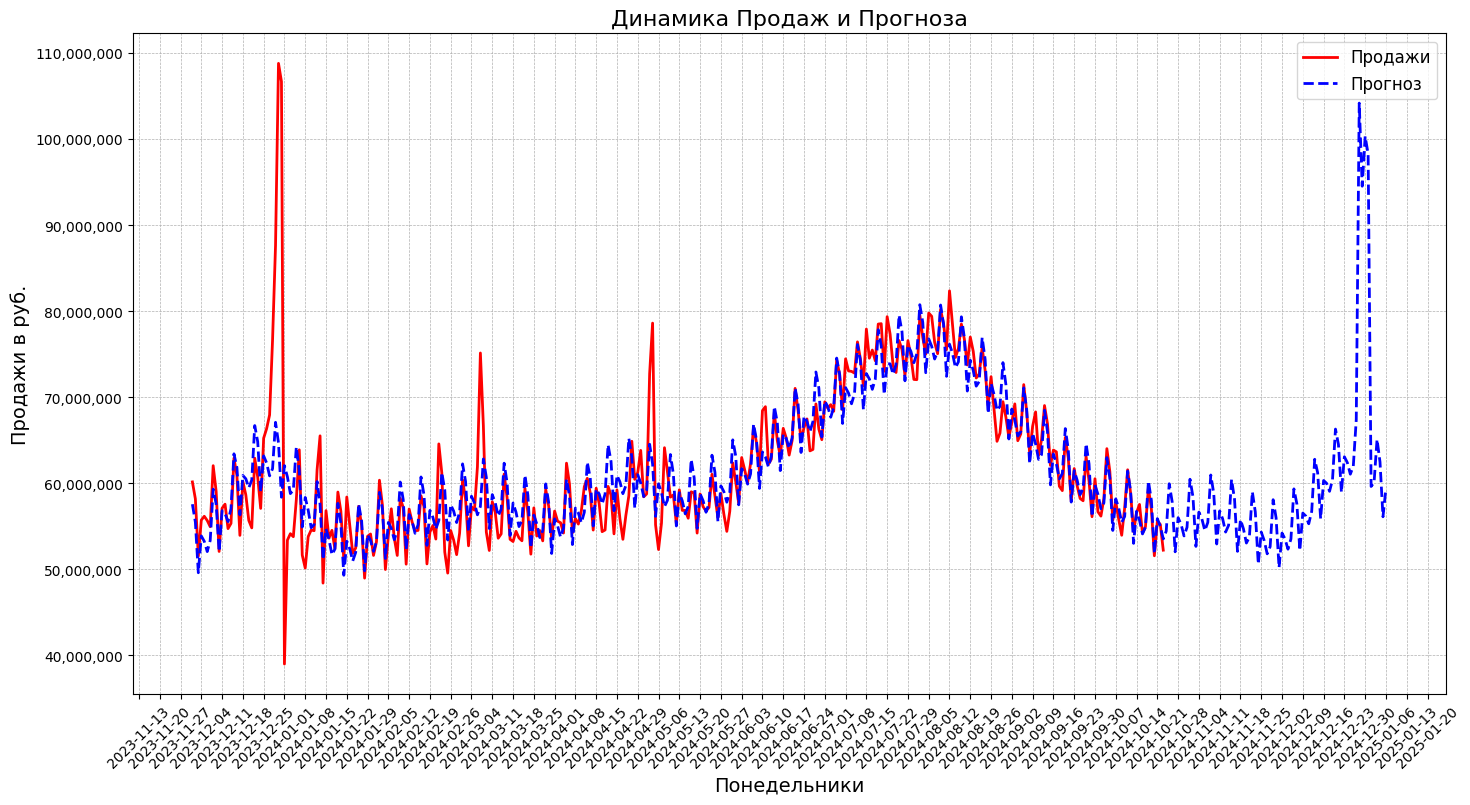

In [2]:
import matplotlib.pyplot as plt                     # График по всем магазинам
import matplotlib.dates as mdates
import pandas as pd

# Загрузка данных прогнозов и фактических продаж
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)

# Переименование столбцов для удобства
data = data.rename(columns={
    'Дата': 'ds', 
    'Номер Магазина': 'store', 
    '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'
})

# Преобразование столбца 'y' в числовой формат
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных начиная с 2024 года
data = data[data['ds'] >= '2023-12-01']

# Суммирование фактических данных по всем магазинам
total_sales = data.groupby('ds').agg({'y': 'sum'}).reset_index()

# Загрузка прогнозов
all_forecasts = pd.read_excel('ForecastNext2Month.xlsx', sheet_name='Sheet1')
all_forecasts['ds'] = pd.to_datetime(all_forecasts['ds'])
filtered_forecasts = all_forecasts[all_forecasts['ds'] >= '2023-12-01']

# Суммирование прогнозов по всем магазинам
summed_forecasts = filtered_forecasts.groupby('ds').agg({'yhat': 'sum'}).reset_index()

# Создание общего графика суммарного прогноза с фактическими данными
plt.figure(figsize=(14, 8))

# Линия фактических продаж
plt.plot(total_sales['ds'], total_sales['y'], label='Продажи', color='red', linewidth=2)

# Линия суммарного прогноза
plt.plot(summed_forecasts['ds'], summed_forecasts['yhat'], label='Прогноз', color='blue', linestyle='--', linewidth=2)

# Настройка заголовка и меток осей
plt.title('Динамика Продаж и Прогноза', fontsize=16)
plt.xlabel('Понедельники', fontsize=14)
plt.ylabel('Продажи в руб.', fontsize=14)

# Отображение легенды
plt.legend(fontsize=12)

# Отображение сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Улучшение форматирования осей
plt.xticks(rotation=45)
plt.tight_layout()

# Добавление разделителей тысяч для оси Y
plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Добавление меток начала каждой недели на ось X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Показ графика
plt.show()


In [ ]:
import matplotlib.pyplot as plt                 # График по выбранному магазину
import matplotlib.dates as mdates
import pandas as pd

# Загрузка данных прогнозов и фактических продаж
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)

# Переименование столбцов для удобства
data = data.rename(columns={
    'Дата': 'ds', 
    'Номер Магазина': 'store', 
    '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'
})

# Преобразование столбца 'y' в числовой формат
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных начиная с 2024 года
data = data[data['ds'] >= '2024-01-01']

# Фильтрация данных по магазину 151
store_id = 148
store_data = data[data['store'] == store_id]

# Загрузка прогнозов
all_forecasts = pd.read_excel('ForecastNextMonth.xlsx', sheet_name='Sheet1')
all_forecasts['ds'] = pd.to_datetime(all_forecasts['ds'])
filtered_forecasts = all_forecasts[all_forecasts['ds'] >= '2024-01-01']

# Фильтрация прогнозов по магазину 151
store_forecasts = filtered_forecasts[filtered_forecasts['store'] == store_id]

# Создание графика прогноза с фактическими данными для магазина 151
plt.figure(figsize=(14, 8))

# Линия фактических продаж
plt.plot(store_data['ds'], store_data['y'], label='Продажи', color='red', linewidth=2)

# Линия прогноза
plt.plot(store_forecasts['ds'], store_forecasts['yhat'], label='Прогноз', color='blue', linestyle='--', linewidth=2)

# Настройка заголовка и меток осей
plt.title(f'Динамика Продаж и Прогноза для магазина {store_id}', fontsize=16)
plt.xlabel('Понедельники', fontsize=14)
plt.ylabel('Продажи в руб.', fontsize=14)

# Отображение легенды
plt.legend(fontsize=12)

# Отображение сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Улучшение форматирования осей
plt.xticks(rotation=45)
plt.tight_layout()

# Добавление разделителей тысяч для оси Y
plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Добавление меток начала каждой недели на ось X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Показ графика
plt.show()
